In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split


# Load data from the CSV file
od.download("https://www.kaggle.com/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions/data")
os.chdir("eeg-brainwave-dataset-feeling-emotions")
os.listdir()
data = pd.read_csv("emotions.csv")

# Separate features and labels
X = data.iloc[:, :-1].values  # All columns except the last one and first row
y = data.iloc[:, -1].values  # The last column except the first row

# Convert labels to numeric values (0: negative, 1: neutral, 2: positive)
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
y = np.array([label_mapping[label] for label in y])

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Reshape X to have the shape (num_samples, sequence_length, num_features)
X = X.view(X.shape[0], 1, X.shape[1])

# Create dataset and dataloaders
dataset = TensorDataset(X, y)

# Decide training dataset size (80% of the complete dataset)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the training set and the test set
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# here we have both training sets
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Dadames
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions


100%|██████████| 11.9M/11.9M [00:00<00:00, 29.4MB/s]


In [ ]:
# This is a classic LSTM architecture used to train the model. I don't alter too much here,
# it's very similar to the architecture that you usually find in other models.

import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters (I chose these for no particular reason at all)
input_size = X.shape[2]  # Number of features per time step
hidden_size = 50
num_layers = 2
num_classes = 3
learning_rate = 0.001
# epoch (how many times the model is gonna be trained)
num_epochs = 20

# Create the model based on the LSTM classifier
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

In [ ]:
# train
import torch.optim as optim

# choose the gpu to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# The loss function. This is the function that quantifies how well an algorithm
# models a dataset. In particular, the Cross Entropy function measures
# the average number of bits needed to identify an event from one probability
# distribution p using the optimal code for another probability distribution q.
criterion = nn.CrossEntropyLoss()

# optimizer (the algorithm that finds the optimal values for each hidden unit)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in training_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Validation

    # after each epoch, we do a validation of the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Epoch [1/20], Loss: 0.9370
Validation Accuracy: 67.21%
Epoch [2/20], Loss: 0.7369
Validation Accuracy: 67.21%
Epoch [3/20], Loss: 0.5715
Validation Accuracy: 68.85%
Epoch [4/20], Loss: 0.7375
Validation Accuracy: 70.73%
Epoch [5/20], Loss: 0.5409
Validation Accuracy: 69.56%
Epoch [6/20], Loss: 0.3959
Validation Accuracy: 69.56%
Epoch [7/20], Loss: 0.6883
Validation Accuracy: 68.85%
Epoch [8/20], Loss: 0.5099
Validation Accuracy: 70.26%
Epoch [9/20], Loss: 0.5927
Validation Accuracy: 70.96%
Epoch [10/20], Loss: 0.5710
Validation Accuracy: 69.79%
Epoch [11/20], Loss: 0.9047
Validation Accuracy: 70.96%
Epoch [12/20], Loss: 1.3037
Validation Accuracy: 69.56%
Epoch [13/20], Loss: 0.8432
Validation Accuracy: 69.56%
Epoch [14/20], Loss: 0.4653
Validation Accuracy: 69.09%
Epoch [15/20], Loss: 0.3582
Validation Accuracy: 70.96%
Epoch [16/20], Loss: 0.5746
Validation Accuracy: 71.43%
Epoch [17/20], Loss: 0.7571
Validation Accuracy: 70.49%
Epoch [18/20], Loss: 0.5737
Validation Accuracy: 71.66%
E

In [ ]:
# We evaluate the model on the validation set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Final Validation Accuracy: {100 * correct / total:.2f}%')

Final Validation Accuracy: 72.60%


In [ ]:
# Test with a specific data row


#Good one
specific_index = 0
#Bad one
#specific_index = 10

# we only take one row from a specific index and its label
specific_data = data.iloc[specific_index, :-1].values.astype(np.float32)
specific_label = data.iloc[specific_index, -1]  # Actual label

# print the row
print("Specific Data Row (Features):", specific_data)
print("Specific Data Row (Full):", data.iloc[specific_index].values)

# Convert the specific data to PyTorch tensor and reshape
specific_data_tensor = torch.tensor(specific_data, dtype=torch.float32).view(1, 1, -1).to(device)
# Make a prediction
model.eval()
with torch.no_grad():
    prediction = model(specific_data_tensor)
    _, predicted_label = torch.max(prediction, 1)
    predicted_label = predicted_label.item()

# Convert numeric prediction back to label
reverse_label_mapping = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}
predicted_label = reverse_label_mapping[predicted_label]

print("Model Prediction for the specific data row:", predicted_label)
print("Actual Label for the specific data row:", specific_label)

Specific Data Row (Features): [   4.62   30.3  -356.   ... -162.   -162.    280.  ]
Specific Data Row (Full): [4.62 30.3 -356.0 ... -162.0 280.0 'NEGATIVE']
Model Prediction for the specific data row: NEGATIVE
Actual Label for the specific data row: NEGATIVE


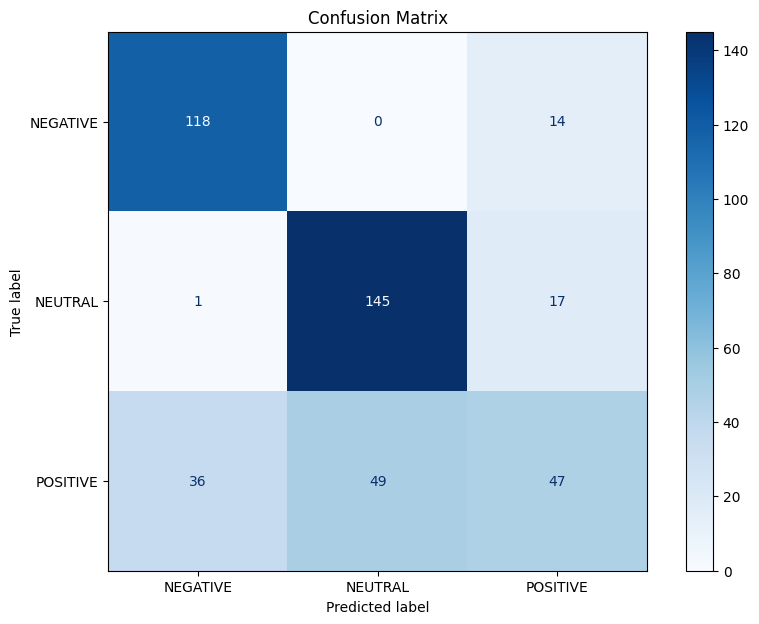

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])

fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
